In [1]:
import pandas as pd
import numpy as np


path = './data/'
output = './output/'



In [2]:
df = pd.read_csv(path+'RegularSeasonDetailedResults.csv')


### This is an experiment on bayesian updating and graphing. I'll probably end up making a medium post about it.
### Ultimately I want it to be the basis for a college basketball model and compare it to my Elo model

First goal:

College basketball can be thought of as a combination of three stats. Offensive efficiency, defensive efficiency, and pace. Let's say Kentucky is playing Louisville in December. The Vegas line looks off to me, and I want to predict the final score.

If I know both team's pace stats, I can predict how many possessions will happen in a game. In further work I will explore how scoring differential impacts pace and efficiency.

Let's say I know that both teams will have 70 possessions. If I also know how efficient the teams will be on those possessions, I can predict the final score. If Kentucky scores 1.1 points per possession, and Louisville scores 1.05, the final score will be somewhere around 77-74.

To start, I'm going to assume every team is average in terms of shooting efficiency, pace, etc. Then, game by game, I'll use bayesian updating to adjust those priors and hopefully by the end of the season we can be relatively certain how efficient teams are.


In [3]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [5]:
def team_by_team(df):
    # preprocessing 
    df = df.loc[df.Season>=2010]
    print(len(df))
    new_cols = []
    for column in list(df):
        if column == 'WLoc':
            new_cols.append('WLoc')
        else:
            column = column.replace("W","")
            column = column.replace("L","Opp")
            new_cols.append(column)

    print(new_cols)
    df.columns=new_cols
    opp_df = df.copy()
    opp_cols = list(opp_df)

    static_cols = ['Season','DayNum','WLoc','NumOT']
    new_oc = []

    for col in opp_cols:
        if col in static_cols:
            new_oc.append(col)
        elif "Opp" in col:
            new_oc.append(col.replace("Opp",""))
        else:
            new_oc.append('Opp'+col)

    print(new_oc)

    opp_df.columns=new_oc
    # adjust location
    reverse = {
        'H':'A',
        'A':'H',
        'N':'N'
    }

    opp_df['WLoc'] = opp_df['WLoc'].replace(reverse)
    opp_df = opp_df[new_cols]
    print(len(df))
    df = pd.concat([df,opp_df],axis=0)
    print(len(df))

    df = df.rename(columns={'WLoc':'Loc'})
    return df



In [6]:
df = team_by_team(df)


47967
['Season', 'DayNum', 'TeamID', 'Score', 'OppTeamID', 'OppScore', 'WLoc', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OppFGM', 'OppFGA', 'OppFGM3', 'OppFGA3', 'OppFTM', 'OppFTA', 'OppOR', 'OppDR', 'OppAst', 'OppTO', 'OppStl', 'OppBlk', 'OppPF']
['Season', 'DayNum', 'OppTeamID', 'OppScore', 'TeamID', 'Score', 'WLoc', 'NumOT', 'OppFGM', 'OppFGA', 'OppFGM3', 'OppFGA3', 'OppFTM', 'OppFTA', 'OppOR', 'OppDR', 'OppAst', 'OppTO', 'OppStl', 'OppBlk', 'OppPF', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']
47967
95934


In [7]:
df.head()

,Season,DayNum,TeamID,Score,OppTeamID,OppScore,Loc,NumOT,FGM,FGA,...,OppFGA3,OppFTM,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF
34074,2010,7,1143,75,1293,70,H,0,24,52,...,21,10,15,11,20,11,17,7,3,24
34075,2010,7,1314,88,1198,72,H,0,34,61,...,23,14,17,13,16,15,20,14,2,18
34076,2010,7,1326,100,1108,60,H,0,39,73,...,17,11,20,11,24,7,13,4,5,16
34077,2010,7,1393,75,1107,43,H,0,29,60,...,28,8,14,12,27,10,32,12,4,27
34078,2010,9,1143,95,1178,61,H,0,29,61,...,18,17,27,14,18,14,15,4,2,21


In [10]:
# let's start with a binomial 3 point distribution

# total 3 pointers made 
FGM3 = df.FGM3.sum()
FGA3 = df.FGA3.sum()

base_rate = np.round(FGM3/FGA3, 2)

print(FGM3)
print(FGA3)
print(base_rate)


633162
1834435
0.35


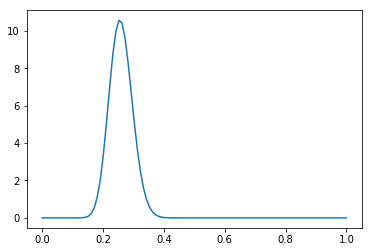

In [27]:
# so, how 'sticky' the prior will be depends on how many samples you use
# if we said the team made 633K/1.8M shots, then the prior wouldn't move
# instead, since we expect variability, we can say the team made 35/100 shots. 
# This is a compromise between not sticky enough and too sticky, and can be adjusted

from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
a =  35
b = 100
x = np.linspace(0, 1.0, 100)
y1 = beta.pdf(x, a, b)
# y2 = beta.pdf(x, 3.25, 3.25)
# y3 = beta.pdf(x, 3, 3)
plt.plot(x, y1, "-")# x, y2, "r--", x, y3, "g--")



In [30]:
# Duke (team code 1181) was bad at 3 point shooting in 2019. 
#Let's see how the distribution evolves over the course of the season
print(df.loc)
# duke = df.loc[df.TeamID==1181]
# duke = df.loc[df.Season==2019]

print(len(duke))


0
